In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF

matplotlib.style.use('ggplot')

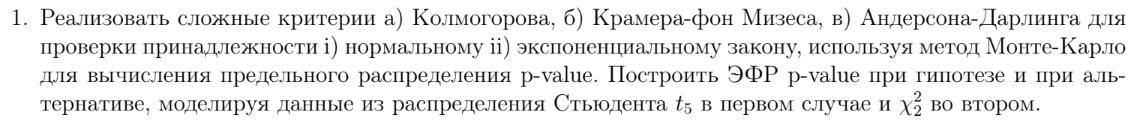

In [35]:
#Генерация квантилей exp, Anderson
def anderson_value(sample, n):
    sample = np.array(sample)
    sample = np.sort(sample)
    
    #Посчитем обратное ОМП
    mle = np.mean(sample)
    
    ans = -n
    for i in range(1, n+1):
        ans -= ((2*i-1)/n*(
            np.log(st.expon.cdf(sample[i-1], scale=mle)) + np.log(1 - st.expon.cdf(sample[n-i], scale=mle))
        ))
    
    return ans

#сгенерируем таблицу приближенных квантиелей
f = open('quantiles/anderson.txt', 'w')

table = []
for i in range(1000):
    sample = sc.stats.expon.rvs(scale=1, size=300)
    val = anderson_value(sample, 300)
    table.append(val)
    
table = np.array(table)
table = np.sort(table)

for i in range(len(table)):
    print(table[i])
    f.write(str(table[i]) + ' ')
    
f.close()

0.1203549107235948
0.12884911585538103
0.12897791252272733
0.13322167949837124
0.13553791931613904
0.1405031905466106
0.1478535455423612
0.1527719479974592
0.15292892553406123
0.1533327335609859
0.15598168757749892
0.15765406087877132
0.1588020908200899
0.16410740931501094
0.16499254190231685
0.16686157141858443
0.16744188933544427
0.16746706886852455
0.16835009422648392
0.1695724323457929
0.1714303147794477
0.17357638708210943
0.17422835940906753
0.17869115009130385
0.17893064299698977
0.17895083546277413
0.18011315661084357
0.18023711826512379
0.1808443714369859
0.1810056906630146
0.1846120176937944
0.18546666129078682
0.1859956777546206
0.1860715960185545
0.18667868633163165
0.18681790572244883
0.1886703219664134
0.18869378670822945
0.1915333329531896
0.19234576411966436
0.1924011246569109
0.1932633157334803
0.19601730104847917
0.1962509686126852
0.20111000476533666
0.2023724883508708
0.20299120007645635
0.20756547123859018
0.20939971441983535
0.21084645224916107
0.2111161835150764


In [36]:
def get_quantile(a):
    f = open('quantiles/anderson.txt', 'r')
    data = f.read()
    data = data.split(" ")
    return float(data[int(a * (len(data)-1))])

def counter(val):
    f = open('quantiles/anderson.txt', 'r')
    data = f.read()
    data = data.split(" ")
    count = 0
    while float(data[count]) <= val:
        count += 1
        if count >= len(data)-1:
            break
    count /= len(data)
    return count

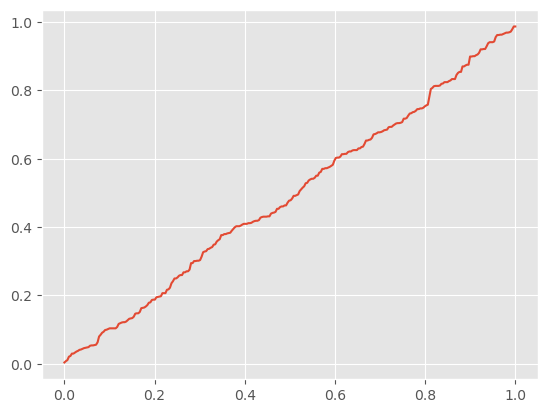

In [44]:
n = 600

#График p-val
t = np.zeros(300)
for i in range(300):
    sample = sc.stats.chi2.rvs(df=2, size=n)
    t[i] = counter(anderson_value(sample, n))

t = np.sort(t)
plt.plot(np.linspace(0,1,300), t)

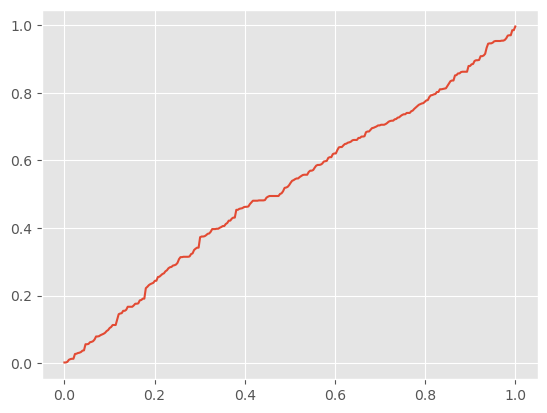

In [45]:
n = 600

#График p-val
t = np.zeros(300)
for i in range(300):
    sample = sc.stats.expon.rvs(scale=100, size=n)
    t[i] = 1-counter(anderson_value(sample, n))

t = np.sort(t)
plt.plot(np.linspace(0,1,300), t)

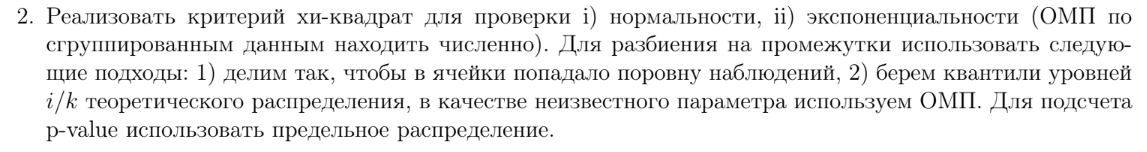

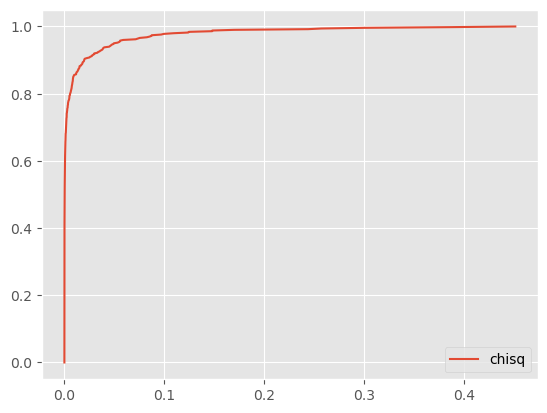

In [108]:
# II)expon
#1)
def likelihood(x, sample, n, bounds):
    ans = 0
    freq = int(n/round(n**0.2))
    for i in range(len(bounds)):
        if i == 0:
            ans += freq*np.log(1e-3 + st.expon.cdf(bounds[i], scale=x))
        else:
            ans += freq*np.log(1e-3 + st.expon.cdf(bounds[i], scale=x) - st.expon.cdf(bounds[i-1], scale=x))
    ans += freq*np.log(1e-4 + 1 - st.expon.cdf(bounds[len(bounds)-1], scale=x))
    return -ans

def chi_mle(sample, n, bounds):
    return sc.optimize.fmin(lambda y: likelihood(y, sample, n, bounds), 2, disp=False)[0]


n = 1000
#фиксируем частоту
k = int(n/round(n**0.2))

chi = []

for i in range(500):
    #В этом случае ожидается сильное отклонение (модуль студента):
    sample = np.abs(st.t.rvs(df=5, size=n))
    sample = np.sort(sample)
    
    #Разобъем выборку на равные части по k, k делит n
    #Первый и последний элементы указывают на границу лучей
    bounds = []
    for j in range(k, n, k):
        bounds.append(sample[j])
        
    #Ищем ОМП
    mle = chi_mle(sample, n, bounds)
    
    #Статистика Пирсона
    chi_val = 0
    for j in range(len(bounds)):
        if j == 0:
            p = st.expon.cdf(bounds[j], scale=mle)
        else:
            p = st.expon.cdf(bounds[j], scale=mle) - st.expon.cdf(bounds[j-1], scale=mle)
        if p <= 1e-3:
            p = 1e-3
        chi_val += (k - n*p)**2/(n*p)
    p = 1 - st.expon.cdf(bounds[len(bounds)-1], scale=mle)
    chi_val += (k - n*p)**2/(n*p)
    
    #добавляем в массив вероятность
    chi.append(1 - st.chi2.cdf(chi_val, df = n/k-2))
  
t = np.linspace(0, 1, 500)
plt.plot(np.sort(chi), t, label='chisq')
plt.legend()

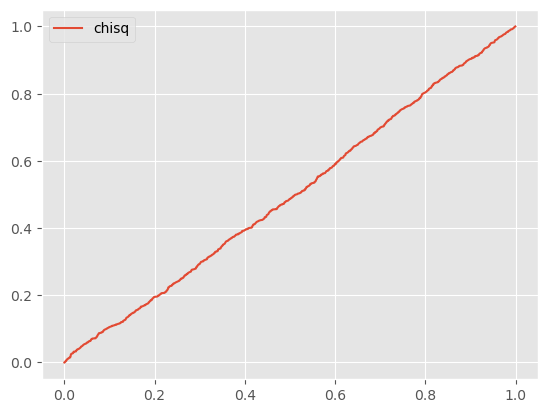

In [98]:
chi = []

for i in range(1000):
    #df=2 отклонения оч слабое
    sample = st.chi2.rvs(df=2, size=n)
    sample = np.sort(sample)
    
    #Разобъем выборку на равные части по k, k делит n
    #Первый и последний элементы указывают на границу лучей
    bounds = []
    for j in range(k, n, k):
        bounds.append(sample[j])
        
    #Ищем ОМП
    mle = chi_mle(sample, n, bounds)
    
    #Статистика Пирсона
    chi_val = 0
    for j in range(len(bounds)):
        if j == 0:
            p = st.expon.cdf(bounds[j], scale=mle)
        else:
            p = st.expon.cdf(bounds[j], scale=mle) - st.expon.cdf(bounds[j-1], scale=mle)
        chi_val += (k - n*p)**2/(n*p)
    p = 1 - st.expon.cdf(bounds[len(bounds)-1], scale=mle)
    chi_val += (k - n*p)**2/(n*p)
    
    #добавляем в массив вероятность
    chi.append(1 - st.chi2.cdf(chi_val, df = n/k-2))
  
t = np.linspace(0, 1, 1000)
plt.plot(np.sort(chi), t, label='chisq')
plt.legend()

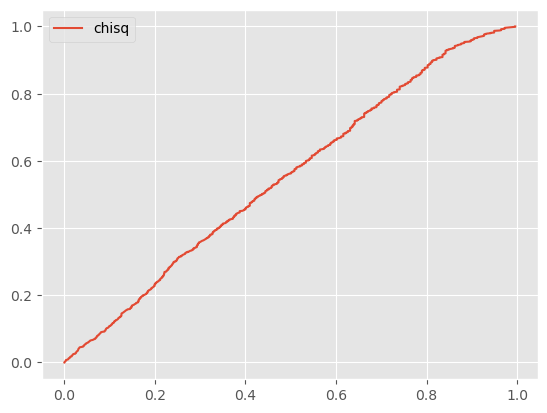

In [6]:
#2)
#ТАКОЙ ЛАЙКЛИХУД КОНСТАНТА Я НЕ ПОНЯЛ ЧТО ХОТЯТ В ЗАДАНИИ И О КАКОМ ОМП РЕЧЬ
################################################################################

n = 1000
k = round(n**0.2)

chi = []

for i in range(1000):
    sample = st.chi2.rvs(df=2, size=n)
    sample = np.sort(sample)
    
    #Ищем ОМП теоретического распределения
    mle = np.mean(sample)
    
    #Статистика Пирсона (делаем +- то же самое, что и в ОМП)
    p = 1/k #вероятность
    l = 0 #указатель на элемент массива
    chi_val = 0

    for j in range(1, k):
        freq = 0
        q = st.expon.ppf(j/k, scale=mle)
        while l <= n-1:
            if sample[l] <= q:
                freq += 1
                l += 1
            else:
                break 
        chi_val += (freq - n*p)**2/(n*p)
        
    chi_val += ((n-l) - n*p)**2/(n*p)

    #добавляем в массив вероятность
    chi.append(1 - st.chi2.cdf(chi_val, df = k-2))
  
t = np.linspace(0, 1, 1000)
plt.plot(np.sort(chi), t, label='chisq')
plt.legend()

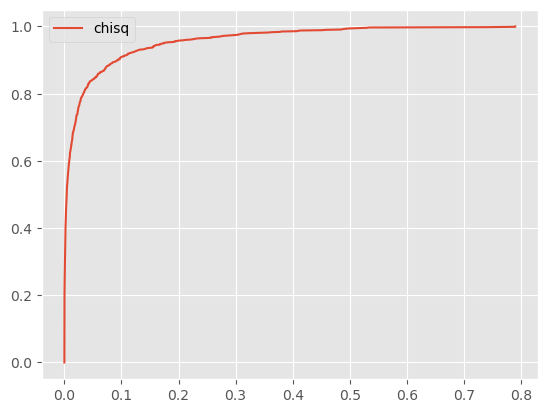

In [7]:
n = 1000
k = round(n**0.2)

chi = []

for i in range(1000):
    sample = np.abs(st.t.rvs(df=3, size=n))
    sample = np.sort(sample)
    
    #Ищем ОМП теоретического распределения
    mle = np.mean(sample)
    
    #Статистика Пирсона (делаем +- то же самое, что и в ОМП)
    p = 1/k #вероятность
    l = 0 #указатель на элемент массива
    chi_val = 0

    for j in range(1, k):
        freq = 0
        q = st.expon.ppf(j/k, scale=mle)
        while l <= n-1:
            if sample[l] <= q:
                freq += 1
                l += 1
            else:
                break 
        chi_val += (freq - n*p)**2/(n*p)
        
    chi_val += ((n-l) - n*p)**2/(n*p)

    #добавляем в массив вероятность
    chi.append(1 - st.chi2.cdf(chi_val, df = k-2))
  
t = np.linspace(0, 1, 1000)
plt.plot(np.sort(chi), t, label='chisq')
plt.legend()

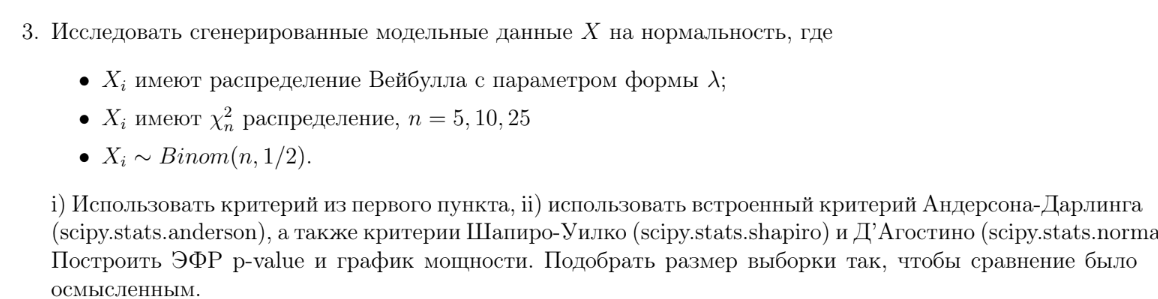

In [30]:
def anderson_value(sample, n):
    sample = np.array(sample)
    sample = np.sort(sample)
    
    #Посчитем обратное ОМП
    m = np.mean(sample)
    s = np.std(sample)
    
    return st.anderson((sample - m)/s).statistic

def get_quantile(a):
    f = open('quantiles/anderson_norm.txt', 'r')
    data = f.read()
    data = data.split(" ")
    return float(data[int(a * (len(data)-1))])

def counter(val):
    f = open('quantiles/anderson_norm.txt', 'r')
    data = f.read()
    data = data.split(" ")
    count = 0
    while float(data[count]) <= val:
        count += 1
        if count >= len(data)-1:
            break
    count /= len(data)
    return count


#сгенерируем таблицу приближенных квантиелей
f = open('quantiles/anderson_norm.txt', 'w')

table = []
for i in range(1000):
    sample = sc.stats.norm.rvs(size=500)
    val = anderson_value(sample, 500)
    table.append(val)
    
table = np.array(table)
table = np.sort(table)

for i in range(len(table)):
    print(table[i])
    f.write(str(table[i]) + ' ')
    
f.close()

0.07613230091601508
0.09312958061775589
0.11140522985624557
0.1148626002062656
0.11546434861162425
0.11773730939489724
0.11951796228555622
0.1256854600288193
0.12640372519035736
0.13135436050470162
0.13142442394496356
0.1328866455776847
0.13322354218848886
0.1347504669077466
0.1370507759791053
0.1372521923074146
0.1387819914194779
0.14150366650648039
0.14161012481611124
0.14237742181546764
0.14366563081114236
0.14441002221133203
0.14455203578836517
0.1456388108435931
0.14612927705297807
0.14631608163421106
0.1490255979443873
0.14947197661115297
0.1495482231161418
0.15134422824388594
0.15153870969351146
0.15299075785065952
0.15474650123911715
0.15590018878867795
0.1573407286693964
0.15752323822846392
0.1578506101474204
0.15814517886860813
0.15815991017478837
0.15975127897246466
0.16030852773872084
0.16179892883474167
0.16214971246290588
0.16296916890780722
0.16392291823734695
0.1644638363490003
0.16625388812735764
0.1670096506247205
0.16719992014679974
0.16839793284503912
0.168890062590

In [71]:
#p-val
def plotter(n, distribution_func):  
    n = 100
    anderson = []
    shapiro = []
    diagostino = []

    for i in range(1000):
        sample = distribution_func.rvs(size=n)

        val = st.anderson((sample - np.mean(sample))/np.std(sample)).statistic #значнеие статистики
        anderson.append(1 - counter(val))

        val = st.shapiro(sample).pvalue
        shapiro.append(val)

        val = st.normaltest(sample).pvalue
        diagostino.append(val)


    t = np.linspace(0, 1, 1000)
    plt.plot(np.sort(anderson), t, label='an')
    plt.plot(np.sort(shapiro), t, label='sh')
    plt.plot(np.sort(diagostino), t, label='da')
    plt.legend()

    
#Мощность
def power_plotter(n, distribution_func):
        P = np.linspace(20, n, int(n/4))
        A = []
        S = []
        D = []
        for p in P:
            anderson = 0
            shapiro = 0
            diagostino = 0

            for i in range(1000):
                sample = distribution_func.rvs(size=int(p))

                val = st.anderson((sample - np.mean(sample))/np.std(sample)).statistic #значнеие статистики
                if (1 - counter(val) < 0.05):
                    anderson += 1

                val = st.shapiro(sample).pvalue
                if (val < 0.05):
                    shapiro += 1

                val = st.normaltest(sample).pvalue
                if (val < 0.05):
                    diagostino += 1
                    
            A.append(anderson/1000)
            S.append(shapiro/1000)
            D.append(diagostino/1000)
        plt.plot(P, A, label='an')
        plt.plot(P, S, label='sh')
        plt.plot(P, D, label='da')
        plt.legend()

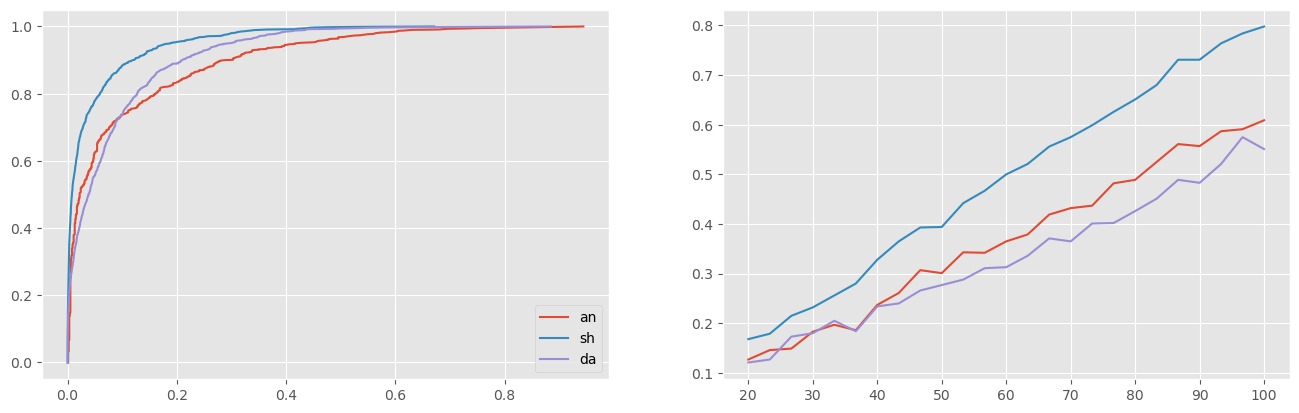

In [69]:
#Вейбулл
plt.subplots_adjust(left = 0.05, right = 2)
plt.subplot(1, 2, 1)
plotter(100, st.weibull_min(2))
plt.subplot(1, 2, 2)
power_plotter(100, st.weibull_min(2))

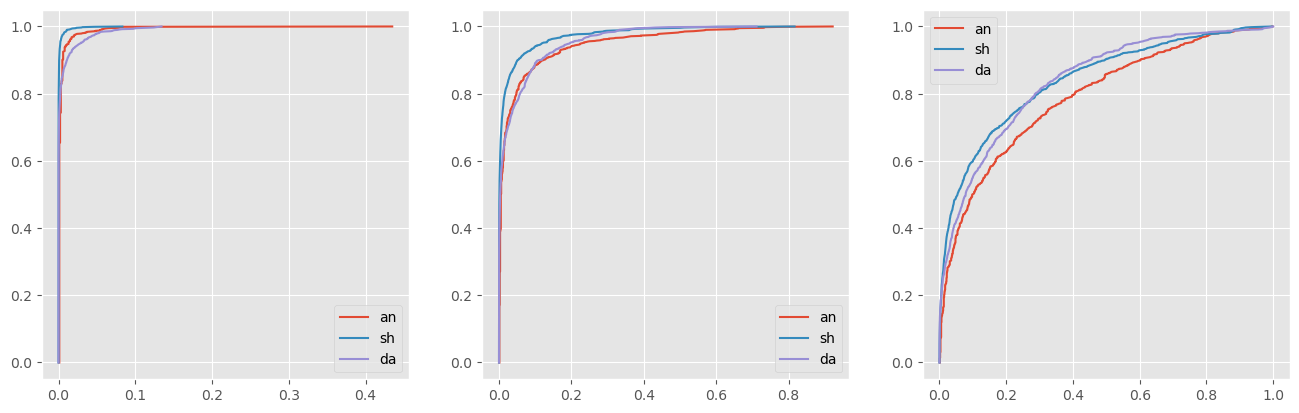

In [52]:
#Хи-квадрат p-val
plt.subplots_adjust(left = 0.05, right = 2)

plt.subplot(1, 3, 1)
plotter(100, st.chi2(df=5))

plt.subplot(1, 3, 2)
plotter(100, st.chi2(df=10))

plt.subplot(1, 3, 3)
plotter(100, st.chi2(df=25))

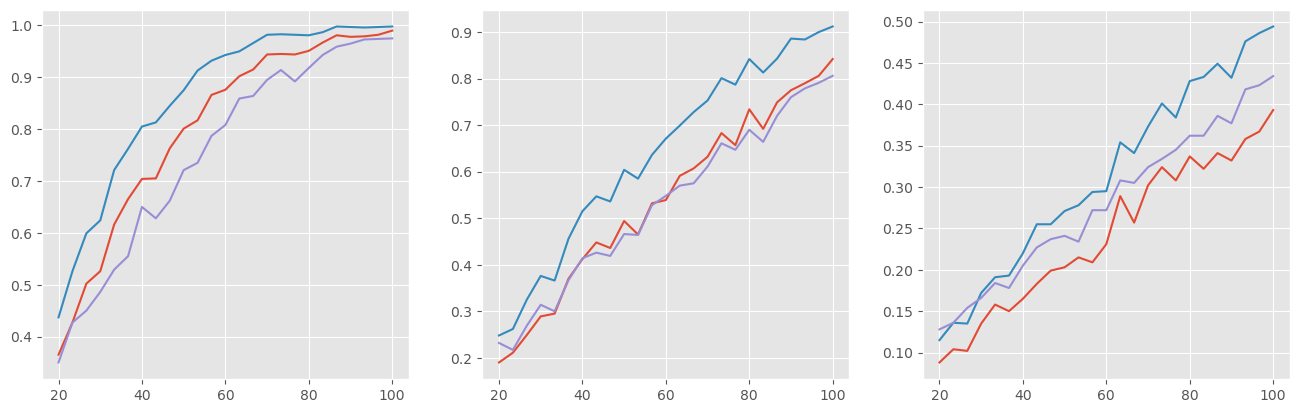

In [70]:
plt.subplots_adjust(left = 0.05, right = 2)

plt.subplot(1, 3, 1)
power_plotter(100, st.chi2(df=5))

plt.subplot(1, 3, 2)
power_plotter(100, st.chi2(df=10))

plt.subplot(1, 3, 3)
power_plotter(100, st.chi2(df=25))

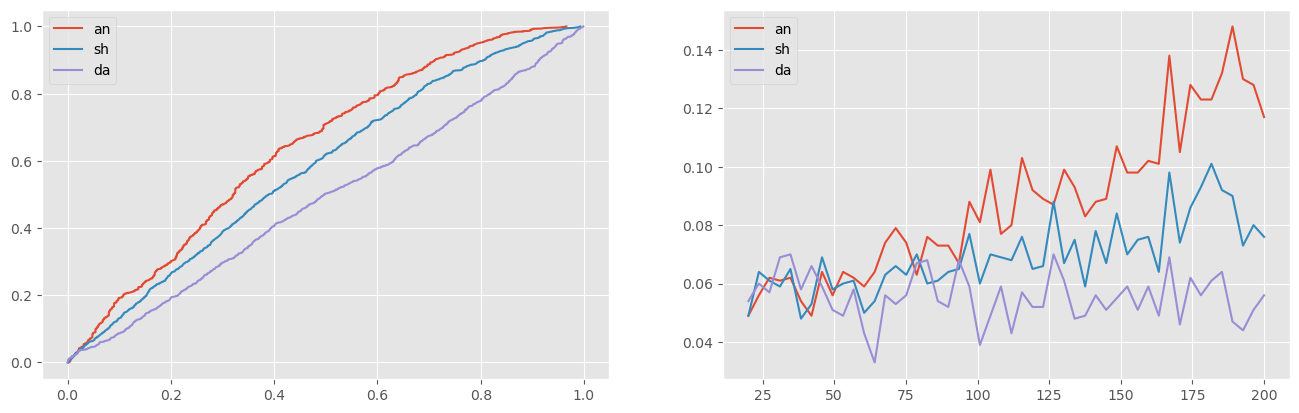

In [72]:
#Бином
plt.subplots_adjust(left = 0.05, right = 2)
plt.subplot(1, 2, 1)
plotter(200, st.binom(200, 1/2))
plt.subplot(1, 2, 2)
power_plotter(200, st.binom(200, 1/2))

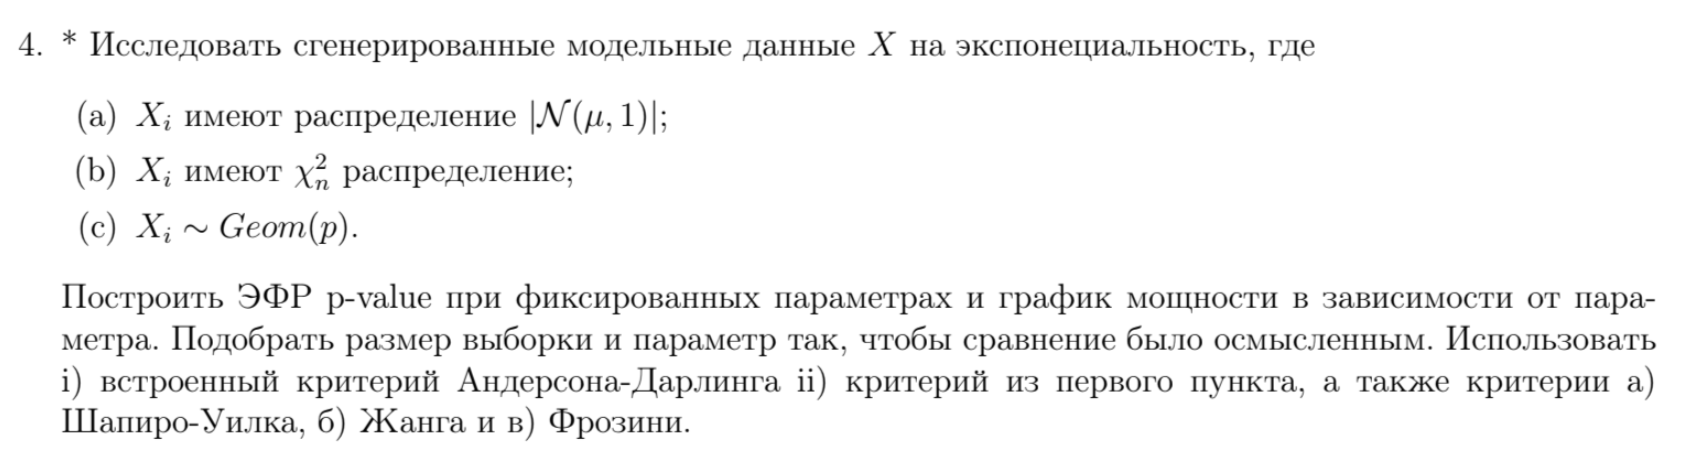

In [11]:
#Андерсон для проверки expon
def anderson_value(sample, n):
    sample = np.array(sample)
    sample = np.sort(sample)
    
    #Посчитем обратное ОМП
    mle = np.mean(sample)
    
    ans = -n
    for i in range(1, n+1):
        ans -= ((2*i-1)/n*(
            np.log(st.expon.cdf(sample[i-1], scale=mle)) + np.log(1 - st.expon.cdf(sample[n-i], scale=mle))
        ))
    
    return ans

def counter(name, val):
    f = open(name, 'r')
    data = f.read()
    data = data.split(" ")
    count = 0
    while float(data[count]) <= val:
        count += 1
        if count >= len(data)-1:
            break
    count /= len(data)
    return count

In [9]:
#Фрозини
def frozini_value(sample, n):
    sample = np.array(sample)
    sample = np.sort(sample)
    
    #Посчитем обратное ОМП
    m = np.mean(sample)
    
    ans = 0
    for i in range(n):
        ans += np.abs(1 - np.exp(-sample[i]/m) - ((i+1) - 0.5)/n)
    
    return ans/(n**0.5)

In [21]:
#Генрация квантилей
f = open('quantiles/frozini.txt', 'w')

table = []
for i in range(1000):
    sample = sc.stats.expon.rvs(scale=1, size=300)
    val = frozini_value(sample, 300)
    table.append(val)
    
table = np.array(table)
table = np.sort(table)

for i in range(len(table)):
    print(table[i])
    f.write(str(table[i]) + ' ')
    
f.close()

0.09444679267719537
0.09594269189386409
0.10077961579094094
0.1025083779800657
0.10297029751858656
0.10617709284049012
0.10810258650565897
0.10863077618672794
0.10902683393507685
0.11167460088815913
0.11199532209157566
0.11348395680648157
0.11415730734293243
0.11520834861757595
0.11574879238664296
0.11624446662457118
0.11708339016013639
0.11725338602546781
0.11783857290018211
0.11901159595095272
0.11924382972623769
0.11981587624595355
0.11997964990515983
0.12003273393615764
0.12045700335110952
0.12186900127696364
0.12225476245932547
0.12332028993554595
0.12338442766564235
0.12366030725993271
0.12485130863136723
0.12498596875532024
0.12589927908552698
0.12609548797318743
0.1265082969735875
0.1266542168725222
0.12693084494970883
0.12731578856608589
0.12862314727701013
0.12917358101149995
0.12922925401594706
0.12945079908423002
0.12974469297060304
0.12977363314981025
0.12999745648192565
0.13030779810099613
0.1305030553361273
0.1306644738736679
0.13088110056985075
0.13094086732123392
0.131

In [7]:
#p-val
def plotter(n, distribution_func, p):  
    anderson = []
    frozini = []

    for i in range(1000):
        if distribution_func == st.norm:
            sample = np.abs(distribution_func(loc=p).rvs(size=n))
        else:
            sample = distribution_func(p).rvs(size=n)
            
        val = anderson_value(sample, n)
        anderson.append(1 - counter('quantiles/anderson.txt', val))

        val = frozini_value(sample, n)
        frozini.append(1 - counter('quantiles/frozini.txt', val))


    t = np.linspace(0, 1, 1000)
    plt.plot(np.sort(anderson), t, label='an')
    plt.plot(np.sort(frozini), t, label='fr')
    plt.legend()
    
def power_plotter(n, distribution_func):
        if distribution_func == st.norm:
            P = np.linspace(0, 1, 20)
        elif distribution_func == st.geom:
            P = np.linspace(0.01, 0.99, 20)
        else:
            P = np.linspace(1, 4, 4)
            
        A = [] 
        F = []
        for p in P:
            anderson = 0
            frozini = 0

            for i in range(1000):
                if distribution_func == st.norm:
                    sample = np.abs(distribution_func(loc=p).rvs(size=n))
                else:
                    sample = distribution_func(p).rvs(size=n)
                

                val = anderson_value(sample, n)
                if (1 - counter('quantiles/anderson.txt', val) < 0.05):
                    anderson += 1

                val = frozini_value(sample, n)
                if (1 - counter('quantiles/frozini.txt', val) < 0.05):
                    frozini += 1
                    
            A.append(anderson/1000)
            F.append(frozini/1000)
        plt.plot(P, A, label='an')
        plt.plot(P, F, label='fr')
        plt.legend()

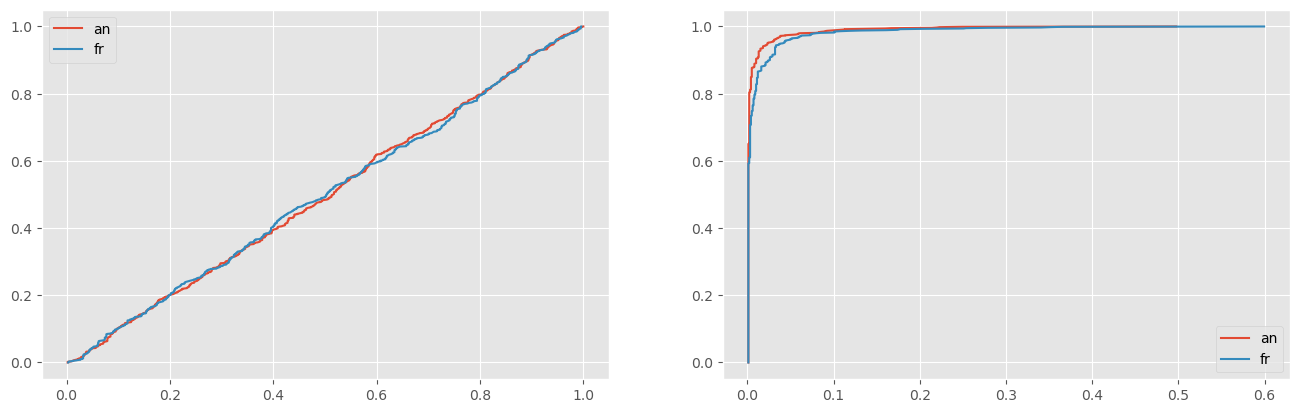

In [15]:
#Хи-квадрат p-val
plt.subplots_adjust(left = 0.05, right = 2)

plt.subplot(1, 2, 1)
plotter(300, st.chi2, 2)

plt.subplot(1, 2, 2)
plotter(200, st.chi2, 3)

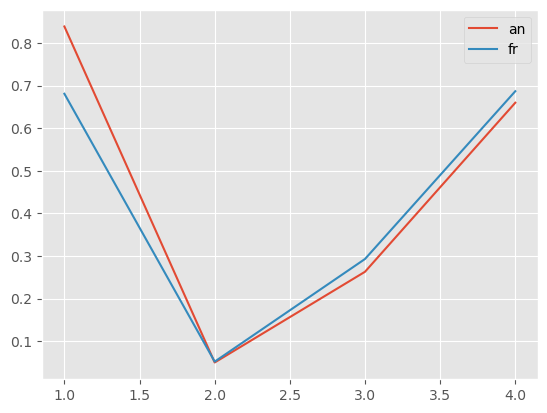

In [23]:
power_plotter(30, st.chi2)

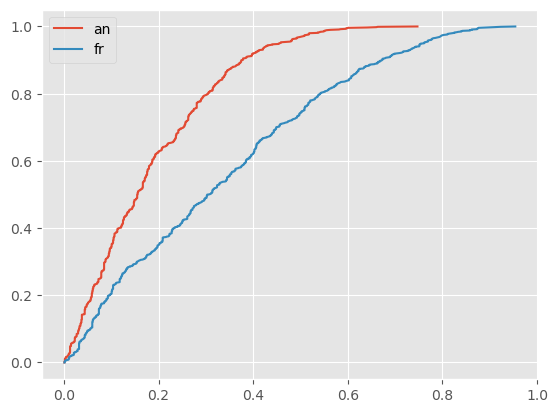

In [24]:
plotter(200, st.geom, 1/20)

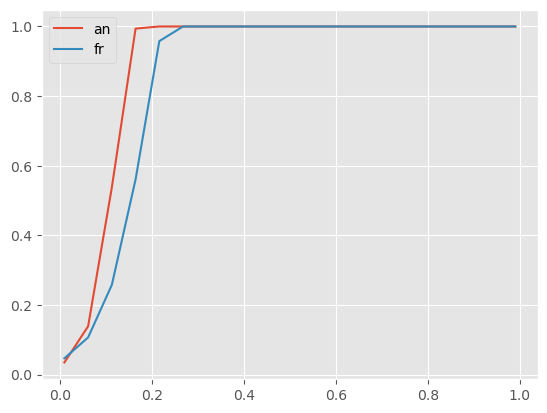

In [25]:
power_plotter(100, st.geom)

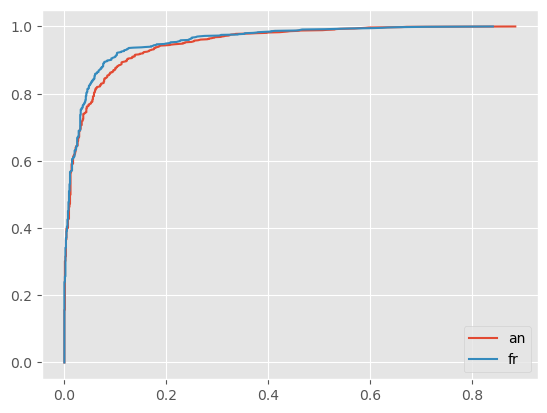

In [26]:
plotter(100, st.norm, 0.01)

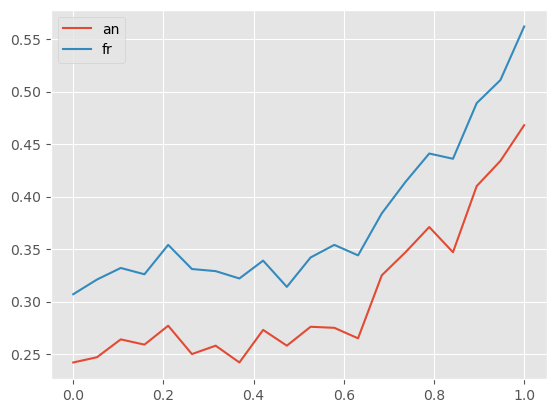

In [27]:
power_plotter(30, st.norm)